In [19]:
import os, sys
global top_path  # the path of the top_level directory
global script_path, data_path, logging_path
top_path = '/scratch/user/zshuying/ppi_mutation/'
sys.path.append(top_path)
pj=os.path.join
script_path, data_path, logging_path= os.path.join(top_path,'scripts'),\
    os.path.join(top_path,'data'),\
    os.path.join(top_path,'logs')
from scripts.baseline1.datasets_baseline1 import *


In [3]:
import pandas as pd
test_set=pd.read_csv('/scratch/user/zshuying/ppi_mutation/data/clinvar/mutant_seq_2019_test_no_error.csv'
)
with open('/scratch/user/zshuying/ppi_mutation/data/baseline1/processed/2019_test_name_list_1050.txt','r') as f:
    test_list=eval(f.readline())
with open('/scratch/user/zshuying/ppi_mutation/data/baseline1/processed/2019_train_name_list_1050.txt','r') as f:
    train_list=eval(f.readline())
with open('/scratch/user/zshuying/ppi_mutation/data/baseline1/processed/2019_val_name_list_1050.txt','r') as f:
    val_list=eval(f.readline())
train_val=pd.read_csv('/scratch/user/zshuying/ppi_mutation/data/clinvar/mutant_seq_2019_1_no_error.csv')
test_actual_df=test_set[test_set['Name'].apply(lambda x:x in test_list)]
test_uniprot=set(test_actual_df.UniProt.unique().tolist())
train_actual_df=train_val[train_val['Name'].apply(lambda x:x in train_list)]
train_uniprot=set(train_actual_df.UniProt.unique().tolist())
val_actual_df=train_val[train_val['Name'].apply(lambda x:x in val_list)]
val_uniprot=set(val_actual_df.UniProt.unique().tolist())

In [4]:
test_actual_df=test_set[test_set['Name'].apply(lambda x:x in test_list)]
test_uniprot=set(test_actual_df.UniProt.unique().tolist())
train_actual_df=train_val[train_val['Name'].apply(lambda x:x in train_list)]
train_uniprot=set(train_actual_df.UniProt.unique().tolist())
val_actual_df=train_val[train_val['Name'].apply(lambda x:x in val_list)]
val_uniprot=set(val_actual_df.UniProt.unique().tolist())

In [8]:
seq_sim_train_test=pd.DataFrame(index=train_actual_df.Name.tolist(),columns=test_actual_df.Name.tolist())
seq_sim_train_val=pd.DataFrame(index=train_actual_df.Name.tolist(),columns=val_actual_df.Name.tolist())

In [41]:
actual_train_val_df=train_val[train_val['Name'].apply(lambda x:x in train_list+val_list)]

In [49]:
val_uniprot_new_list=list(train_uniprot)[:300]
train_uniprot_new_list=list(train_uniprot)[300:]
val_new_name_list=actual_train_val_df[actual_train_val_df['UniProt'].apply(lambda x:x in val_uniprot_new_list)]['Name'].tolist()
train_new_name_list=actual_train_val_df[actual_train_val_df['UniProt'].apply(lambda x:x in train_uniprot_new_list)]['Name'].tolist()

In [52]:
len(val_new_name_list),len(train_new_name_list)
with open ('/scratch/user/zshuying/ppi_mutation/data/baseline1/processed/2019_train_name_list_manual1.txt','w') as f:
    f.writelines(str(train_new_name_list))
with open ('/scratch/user/zshuying/ppi_mutation/data/baseline1/processed/2019_val_name_list_manual1.txt','w') as f:
    f.writelines(str(val_new_name_list))

In [8]:
with open('/scratch/user/zshuying/ppi_mutation/data/baseline1/processed/2019_train')

array(['Q5FYB1', 'P47870', 'P18507', ..., 'Q96MF2', 'Q9BYJ1', 'Q9NPC6'],
      dtype=object)

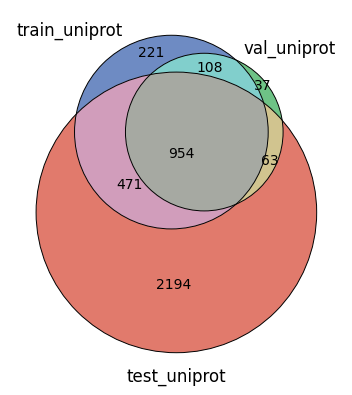

In [14]:
from matplotlib_venn import venn3, venn3_circles,venn3_unweighted
venn3([train_uniprot, val_uniprot, test_uniprot],
        set_colors=('#3E64AF', '#3EAF5D', '#D74E3B'),
        set_labels=('train_uniprot',
                    'val_uniprot',
                    'test_uniprot'),
        alpha=0.75)
venn3_circles([train_uniprot, val_uniprot, test_uniprot], lw=0.7)

In [17]:
uniprots=set(pd.read_csv(pj(top_path,'ppi_seq_huri_humap.csv'))['UniProt'].unique().tolist())

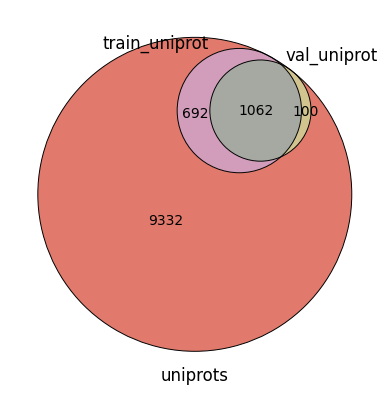

In [18]:
venn3([train_uniprot, val_uniprot, uniprots],
        set_colors=('#3E64AF', '#3EAF5D', '#D74E3B'),
        set_labels=('train_uniprot',
                    'val_uniprot',
                    'uniprots'),
        alpha=0.75)
venn3_circles([train_uniprot, val_uniprot, uniprots], lw=0.7)

### Protein similarity

In [3]:
from torch_sparse import SparseTensor
loader = variantPPI.train_dataloader()
for batch in loader:
    adj = SparseTensor(row=batch.edge_index[0], col=batch.edge_index[1])
    break

In [10]:
import sys
import numpy as np
from Bio.PDB.DSSP import dssp_dict_from_pdb_file

from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist #SZ add

matrix = matlist.blosum62

import re
import string
import random

import networkx as nx # for graph similarity


def sequence_indentity(seq_1, seq_2, version = 'BLAST'):
    '''Calculate the identity between two sequences
    :param seq_1, seq_2: protein sequences
    :type seq_1, seq_2: str
    :param version: squence identity version
    :type version: str, optional
    :return: sequence identity
    :rtype: float
    '''
    l_x = len(seq_1)
    l_y = len(seq_2)
    X = seq_1.upper()
    Y = seq_2.upper()

    if version == 'BLAST':
        alignments = pairwise2.align.globaldd(X,Y, matrix,-11,-1,-11,-1)   # Consistent with Blast P grobal alignment
        max_iden = 0
        for i in alignments:
            same = 0
            for j in range(i[-1]):
                if i[0][j] == i[1][j] and i[0][j] != '-':
                    same += 1
            iden = float(same)/float(i[-1])
            if iden > max_iden:
                max_iden = iden
        identity = max_iden
    elif version == 'Gap_exclude':
        l = min(l_x,l_y)
        alignments = pairwise2.align.globaldd(X,Y, matrix,-11,-1,-11,-1)   # Consistent with Blast P grobal alignment
        max_same = 0
        for i in alignments:
            same = 0
            for j in range(i[-1]):
                if i[0][j] == i[1][j] and i[0][j] != '-':
                    same += 1
            if same > max_same:
                max_same = same
        identity = float(max_same)/float(l)
    else:
        print('Error! No sequence identity version named %s!'%version)
    return identity

In [11]:
for i in range(20):
    for j in range(20):
        seq_sim_train_test.loc[train_actual_df.iloc[i,:]['Name'],test_actual_df.iloc[i,:]['Name']]=sequence_indentity(train_actual_df.iloc[i,:]['Seq'],test_actual_df.iloc[i,:]['Seq'])

In [16]:
seq_sim_train_test.mean(axis=None)

0.2803890598620105

In [17]:
for i in range(20):
    for j in range(20):
        seq_sim_train_val.loc[train_actual_df.iloc[i,:]['Name'],val_actual_df.iloc[i,:]['Name']]=sequence_indentity(train_actual_df.iloc[i,:]['Seq'],val_actual_df.iloc[i,:]['Seq'])

In [18]:
seq_sim_train_val.mean(axis=None)

0.12994522342521814

In [2]:
variantPPI=VariantPPIModule(root=pj(data_path,'baseline1'),clinvar_csv=pj(data_path,'clinvar','mutant_seq_2019_1_no_error.csv'),variant_embedding_path=pj(data_path,'baseline0','2019_variant_embds.pt'),
                            wild_embedding_path=pj(data_path,'baseline0','all_wild_embeddings.pt'),batch_size=20,num_workers=15,random_seed=1050,train_val_ratio=0.8)
# loader = variantPPI.train_dataloader()esxdhgfdesxdfxsds5xsdeww3dedrdffed des34rtedc
# loader=VariantRandomWalkSamler(variantPPI.trainset,walk_length=3,shuffle=True,batch_size=variantPPI.batch_size,num_workers=variantPPI.num_workers)
# for batch in loader:
#     batch
#     break



Split dataset into train, val with the rate of 0.8


In [30]:
CONFIG_PATH='/scratch/user/zshuying/ppi_mutation/configs'
import yaml

def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config


config = load_config('b1_test.yaml')


In [9]:
import torch

a=torch.load('/scratch/user/zshuying/ppi_mutation/data/baseline1/wild_esm_embds_0.pt')
print('before update, len(a)=%s'%len(a))
b=torch.load('/scratch/user/zshuying/ppi_mutation/data/baseline1/wild_esm_embds_1.pt')
c=torch.load('/scratch/user/zshuying/ppi_mutation/data/baseline1/wild_esm_embds_2.pt')
d=torch.load('/scratch/user/zshuying/ppi_mutation/data/baseline1/wild_esm_embds_3.pt')
a.update(b)
a.update(c)
a.update(d)



print('after update, len(a)=%s'%len(a))
torch.save(e,'/scratch/user/zshuying/ppi_mutation/data/baseline1/all_wild_esm_embds.pt')

before update, len(a)=2797
after update, len(a)=11186


In [7]:
batch.x[0].shape,batch.x[1].shape,batch.x[2].shape

(torch.Size([223720, 5760]), torch.Size([115200]), torch.Size([20]))

In [10]:
exclude_self=[item for item in interactions if '-' in item]

In [11]:
interactions_eges=[(item.split('-')[0],item.split('-')[1]) for item in exclude_self]

In [12]:
interactions_eges

[('O43741', 'Q9P0T4'),
 ('Q9Y2R9', 'O60783'),
 ('O14958', 'Q9ULJ3'),
 ('Q96GF1', 'Q8NBI2'),
 ('Q13136', 'Q8NHQ1'),
 ('Q08117', 'Q9NWQ4'),
 ('O14879', 'Q96CS2'),
 ('P59817', 'Q86YH2'),
 ('Q9BYU1', 'Q5MJ09'),
 ('Q96LB9', 'Q9UHD4'),
 ('Q6UWI2', 'Q9UHD9'),
 ('Q8IUQ4', 'Q9UPY8'),
 ('Q7Z6G3', 'Q9NP79'),
 ('Q9UMS4', 'Q13435'),
 ('P31937', 'P21964'),
 ('Q93062', 'Q92567'),
 ('Q9NP66', 'Q96BS2'),
 ('Q12905', 'Q08211'),
 ('Q9H9Y6', 'O15160'),
 ('P18031', 'Q9NPL8'),
 ('O43561', 'Q8NBJ4'),
 ('Q9NPQ8', 'Q9Y371'),
 ('Q9UPZ6', 'Q9NY72'),
 ('Q8N1B4', 'Q6NYC8'),
 ('Q13630', 'P49903'),
 ('Q9BQY4', 'Q3LI64'),
 ('P61970', 'Q8IY57'),
 ('Q99459', 'Q08AF8'),
 ('Q86U28', 'Q9H5Z6'),
 ('Q92917', 'P31321'),
 ('P34810', 'Q96CS7'),
 ('O43395', 'Q9Y2I6'),
 ('P54105', 'P62308'),
 ('Q9UI95', 'Q9C0B1'),
 ('P86478', 'Q03989'),
 ('A8MQ03', 'Q9NVF9'),
 ('Q08379', 'Q96C55'),
 ('P55209', 'P19338'),
 ('Q9H2F3', 'Q9Y320'),
 ('Q93062', 'Q9BVN2'),
 ('Q9NW97', 'Q9H6H4'),
 ('Q7Z6R9', 'P0C7H8'),
 ('P83876', 'Q96D03'),
 ('Q17RD7',

In [1]:
import networkx as nx
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
G=nx.Graph(name='Protein Interaction Graph')
with open('/scratch/user/zshuying/ppi_mutation/ppi_huri_humap.txt','r') as f:
    interactions=list(eval(f.readline()))
uniprots=pd.read_csv('/scratch/user/zshuying/ppi_mutation/ppi_seq_huri_humap.csv')['UniProt'].tolist()
useful_interactions=[item for item in interactions if (item.split('-')[0] in uniprots and item.split('-')[1] in uniprots)]


In [ ]:
import pandas as pd
test_set=pd.read_csv('/scratch/user/zshuying/ppi_mutation/data/clinvar/mutant_seq_2019_test_no_error.csv'
)
with open('/scratch/user/zshuying/ppi_mutation/data/baseline1/processed/2019_test_name_list_1050.txt','r') as f:
    test_list=eval(f.readline())
with open('/scratch/user/zshuying/ppi_mutation/data/baseline1/processed/2019_train_name_list_1050.txt','r') as f:
    train_list=eval(f.readline())
with open('/scratch/user/zshuying/ppi_mutation/data/baseline1/processed/2019_val_name_list_1050.txt','r') as f:
    val_list=eval(f.readline())
train_val=pd.read_csv('/scratch/user/zshuying/ppi_mutation/data/clinvar/mutant_seq_2019_1_no_error.csv')
test_actual_df=test_set[test_set['Name'].apply(lambda x:x in test_list)]
test_uniprot=set(test_actual_df.UniProt.unique().tolist())
train_actual_df=train_val[train_val['Name'].apply(lambda x:x in train_list)]
train_uniprot=set(train_actual_df.UniProt.unique().tolist())
val_actual_df=train_val[train_val['Name'].apply(lambda x:x in val_list)]
val_uniprot=set(val_actual_df.UniProt.unique().tolist())

In [13]:
G.add_edges_from(useful_interactions)

In [14]:
print(G)

Graph named 'Protein Interaction Graph' with 11340 nodes and 72955 edges


In [15]:
print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))


Average degree 12.866843033509701


In [16]:
12**4

20736

In [20]:
def merge_values_from_keys(dictionary, keys):
    merged_values = set()

    for key in keys:
        if key in dictionary:
            merged_values.update(dictionary[key])

    return merged_values
k_hop=pd.DataFrame(columns=['1-hop neighbors','2-hop neighbors','3-hop neighbors','4-hop neighbors','5-hop neighbors','6-hop neighbors'])
for n, nbrs in G.adj.items():
    k_hop.loc[n,'1-hop neighbors']= len(nbrs)
    hop2=merge_values_from_keys(G.adj,set(nbrs.keys()))
    hop12=hop2.union(set(nbrs.keys()))
    k_hop.loc[n,'2-hop neighbors']= len(hop12)
    hop3=merge_values_from_keys(G.adj,hop2)
    hop123=hop3.union(hop12)
    k_hop.loc[n,'3-hop neighbors']= len(hop123)
    hop4=merge_values_from_keys(G.adj,hop3)
    hop1234=hop4.union(hop123)
    k_hop.loc[n,'4-hop neighbors']= len(hop1234)  
    hop5=merge_values_from_keys(G.adj,hop4)
    hop12345=hop4.union(hop1234)
    k_hop.loc[n,'5-hop neighbors']= len(hop12345) 
    hop6=merge_values_from_keys(G.adj,hop5)
    hop123456=hop6.union(hop12345)
    k_hop.loc[n,'6-hop neighbors']= len(hop123456) 

discard interactions which contain items that do not have sequences available

In [17]:
uniprots=pd.read_csv('/scratch/user/zshuying/ppi_mutation/ppi_seq_huri_humap.csv')['UniProt'].tolist()


In [19]:
useful_interactions=[item for item in interactions if (item.split('-')[0] in uniprots and item.split('-')[1] in uniprots)]


In [20]:
with open('/scratch/user/zshuying/ppi_mutation/ppi_huri_humap.txt','w') as f:
    f.writelines(str(useful_interactions))

In [13]:
uniprots

0        Q9BQA9
1        Q8TAK5
2        P12956
3        P03999
4        O75787
          ...  
11181    O43581
11182    P48506
11183    P35244
11184    P63252
11185    Q13308
Name: UniProt, Length: 11186, dtype: object

In [16]:
'Q9BQA9' in uniprots.tolist()

True

In [10]:
# import torch
l=['/scratch/user/zshuying/ppi_mutation/data/baseline0/val_embds_%s.pt'%i for i in range(10)]
d0=torch.load('/scratch/user/zshuying/ppi_mutation/data/baseline0/val_embds_0.pt',map_location='cpu')
for item in l[1:]:
    d0.update(torch.load(item,map_location='cpu'))
torch.save(d0,'/scratch/user/zshuying/ppi_mutation/data/baseline0/2019_test_variant_embds.pt')

In [7]:
d0=torch.load('/scratch/user/zshuying/ppi_mutation/data/baseline0/val_embds_0.pt',map_location='cpu')


In [9]:
d0.update(torch.load(item,map_location='cpu'))

In [32]:
import torch
a=torch.load('/scratch/user/zshuying/ppi_mutation/data/baseline0/2019_test_variant_embds.pt',map_location='cpu')
with open('/scratch/user/zshuying/ppi_mutation/data/baseline1/processed/2019_test_variant_name_list.txt','r') as f:
    variant_name_list=eval(f.readline())

In [34]:
for name in variant_name_list:
    try:a[name]['embs'],a[name]['UniProt'],a[name]['label']
    except KeyError:
        variant_name_list.remove(name)
        print('%s removed'%name)

with open('/scratch/user/zshuying/ppi_mutation/data/baseline1/processed/2019_test_variant_name_list.txt','w') as f:
    f.writelines(str(variant_name_list))

In [7]:
a['NM_000071.2(CBS):c.919G>A (p.Gly307Ser)']

KeyError: 'NM_000071.2(CBS):c.919G>A (p.Gly307Ser)'

In [30]:
variant_name_list

['NM_001012301.4(ARSI):c.680G>A (p.Arg227His)',
 'NM_021911.2(GABRB2):c.895A>T (p.Ile299Phe)',
 'NM_198903.2(GABRG2):c.501C>A (p.Asn167Lys)',
 'NM_001034850.2(RETREG1):c.571C>T (p.Gln191Ter)',
 'NM_016222.4(DDX41):c.364G>T (p.Glu122Ter)',
 'NM_133433.4(NIPBL):c.3455C>G (p.Ser1152Ter)',
 'NM_138413.4(HOGA1):c.769T>G (p.Cys257Gly)',
 'NM_001201543.2(FAM161A):c.685C>T (p.Arg229Ter)',
 'NM_000071.2(CBS):c.434C>T (p.Pro145Leu)',
 'NM_000274.3(OAT):c.1186C>T (p.Arg396Ter)',
 'NM_000274.3(OAT):c.1124G>C (p.Gly375Ala)',
 'NM_000274.3(OAT):c.1058G>A (p.Gly353Asp)',
 'NM_000274.3(OAT):c.1276C>T (p.Arg426Ter)',
 'NM_001034850.2(RETREG1):c.433C>T (p.Gln145Ter)',
 'NM_020312.4(COQ9):c.730C>T (p.Arg244Ter)',
 'NM_000317.3(PTS):c.347A>G (p.Asp116Gly)',
 'NM_000130.4(F5):c.5189A>G (p.Tyr1730Cys)',
 'NM_000130.4(F5):c.6304C>T (p.Arg2102Cys)',
 'NM_000312.3(PROC):c.226G>A (p.Val76Met)',
 'NM_000312.3(PROC):c.814C>T (p.Arg272Cys)',
 'NM_015702.3(MMADHC):c.748C>T (p.Arg250Ter)',
 'NM_000181.4(GUSB):c.1521

0 gcn1_train_roc
1 gcn1_train_prc
2 gcn1_val_roc
3 gcn1_val_prc
4 gcn1_val_loss


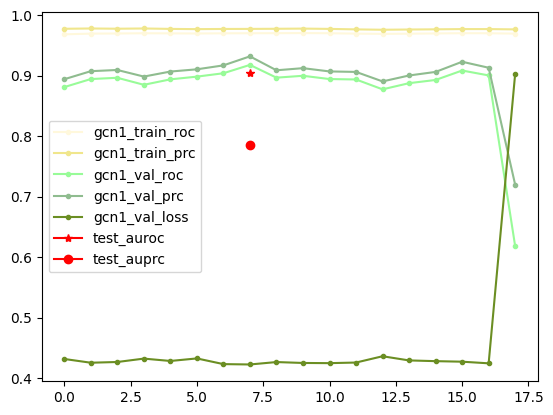

In [29]:
import matplotlib.pyplot as plt
plt.figure()
color_list=['cornsilk','khaki','palegreen','darkseagreen','olivedrab']
for i,column in enumerate(gcn1.columns):
    print(i,column)
    plt.plot(gcn1[column],label=column,marker='.',color=color_list[i])

plt.plot(7,0.9054,marker='*',color='r',label='test_auroc')
plt.plot(7,0.7853,marker='o',color='r',label='test_auprc')
plt.legend()

0 gcn2_train_roc
1 gcn2_train_prc
2 gcn2_val_roc
3 gcn2_val_prc
4 gcn2_val_loss


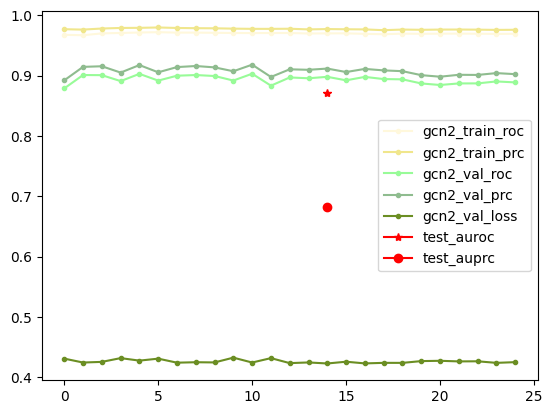

In [25]:
plt.figure()
color_list=['cornsilk','khaki','palegreen','darkseagreen','olivedrab']
for i,column in enumerate(gcn2.columns):
    print(i,column)
    plt.plot(gcn2[column],label=column,marker='.',color=color_list[i])

plt.plot(14,0.871777,marker='*',color='r',label='test_auroc')
plt.plot(14,0.68195,marker='o',color='r',label='test_auprc')
plt.legend()

0 gcn3_train_roc
1 gcn3_train_prc
2 gcn3_val_roc
3 gcn3_val_prc
4 gcn3_val_loss


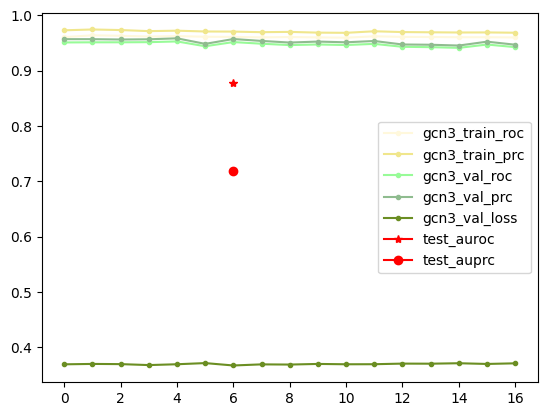

In [28]:
plt.figure()
color_list=['cornsilk','khaki','palegreen','darkseagreen','olivedrab']
for i,column in enumerate(gcn3.columns):
    print(i,column)
    plt.plot(gcn3[column],label=column,marker='.',color=color_list[i])

plt.plot(6,0.877741,marker='*',color='r',label='test_auroc')
plt.plot(6,0.719111,marker='o',color='r',label='test_auprc')
plt.legend()

0 gat3_train_roc
1 gat3_train_prc
2 gat3_val_roc
3 gat3_val_prc
4 gat3_val_loss


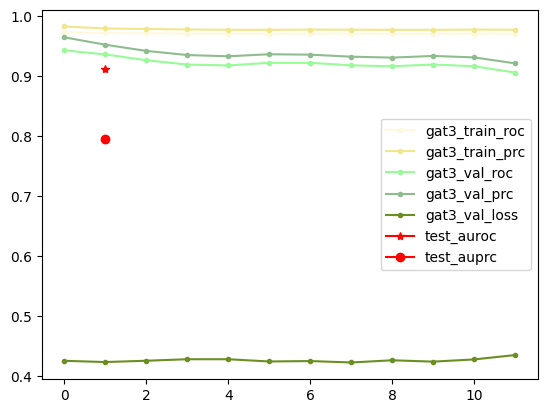

In [31]:
plt.figure()
color_list=['cornsilk','khaki','palegreen','darkseagreen','olivedrab']
for i,column in enumerate(gat3.columns):
    print(i,column)
    plt.plot(gat3[column],label=column,marker='.',color=color_list[i])

plt.plot(1,0.910857,marker='*',color='r',label='test_auroc')
plt.plot(1,0.794892,marker='o',color='r',label='test_auprc')
plt.legend()

In [22]:
import pandas as pd
def split_column(column):
    l=[float(i) for i in column.split("\n")]
    print(l)
    return l
gcn1=pd.DataFrame(columns=['gcn1_train_roc','gcn1_train_prc','gcn1_val_roc','gcn1_val_prc','gcn1_val_loss'])
gcn1.gcn1_train_roc=split_column('''0.9687
0.9699
0.9701
0.9705
0.9703
0.9701
0.9704
0.9705
0.9706
0.9708
0.9705
0.9699
0.9695
0.9698
0.9702
0.9706
0.9705
0.9699''')
gcn1.gcn1_train_prc=split_column('''0.9779
0.9784
0.9780
0.9784
0.9777
0.9773
0.9776
0.9777
0.9779
0.9782
0.9777
0.9769
0.9763
0.9767
0.9770
0.9774
0.9774
0.9769''')
gcn1.gcn1_val_roc=split_column('''0.8815
0.8948
0.8969
0.8853
0.8943
0.8988
0.9044
0.9182
0.8971
0.9002
0.8948
0.8941
0.8778
0.8880
0.8933
0.9089
0.9008
0.6184''')
gcn1.gcn1_val_prc=split_column('''0.8945
0.9078
0.9098
0.8989
0.9072
0.9109
0.9174
0.9323
0.9093
0.9128
0.9074
0.9066
0.8909
0.9007
0.9066
0.9234
0.9135
0.7201''')
gcn1.gcn1_val_loss=split_column('''0.4321
0.4259
0.4271
0.4327
0.4288
0.4330
0.4236
0.4230
0.4270
0.4255
0.4252
0.4262
0.4366
0.4297
0.4285
0.4276
0.4249
0.9037''')

[0.9687, 0.9699, 0.9701, 0.9705, 0.9703, 0.9701, 0.9704, 0.9705, 0.9706, 0.9708, 0.9705, 0.9699, 0.9695, 0.9698, 0.9702, 0.9706, 0.9705, 0.9699]
[0.9779, 0.9784, 0.978, 0.9784, 0.9777, 0.9773, 0.9776, 0.9777, 0.9779, 0.9782, 0.9777, 0.9769, 0.9763, 0.9767, 0.977, 0.9774, 0.9774, 0.9769]
[0.8815, 0.8948, 0.8969, 0.8853, 0.8943, 0.8988, 0.9044, 0.9182, 0.8971, 0.9002, 0.8948, 0.8941, 0.8778, 0.888, 0.8933, 0.9089, 0.9008, 0.6184]
[0.8945, 0.9078, 0.9098, 0.8989, 0.9072, 0.9109, 0.9174, 0.9323, 0.9093, 0.9128, 0.9074, 0.9066, 0.8909, 0.9007, 0.9066, 0.9234, 0.9135, 0.7201]
[0.4321, 0.4259, 0.4271, 0.4327, 0.4288, 0.433, 0.4236, 0.423, 0.427, 0.4255, 0.4252, 0.4262, 0.4366, 0.4297, 0.4285, 0.4276, 0.4249, 0.9037]


In [30]:
import pandas as pd
def split_column(column):
    l=[float(i) for i in column.split("\n")]
    print(l)
    return l
gat3=pd.DataFrame(columns=['gat3_train_roc','gat3_train_prc','gat3_val_roc','gat3_val_prc','gat3_val_loss'])
gat3.gat3_train_roc=split_column('''0.972843945
0.9710919261
0.9709126949
0.9701349735
0.9701256752
0.9700226784
0.9703041315
0.970127821
0.9699161053
0.969788909
0.9703064561
0.9701117277''')
gat3.gat3_train_prc=split_column('''0.9821230769
0.978777647
0.9780445099
0.9771184325
0.9766433239
0.9764785767
0.9769482017
0.9767394066
0.9765312672
0.9765180945
0.9769120812
0.9767392278''')
gat3.gat3_val_roc=split_column('''0.9423689842
0.9355597496
0.9259744883
0.9186586142
0.9172596931
0.9216186404
0.9216186404
0.9173865914
0.9158309698
0.9187953472
0.9159045219
0.9053275585''')
gat3.gat3_val_prc=split_column('''0.9640417099
0.9517646432
0.9414642453
0.9345885515
0.9324707389
0.9358639717
0.9351686835
0.9318324924
0.930267334
0.9330843091
0.9306157231
0.9207020998''')
gat3.gat3_val_loss=split_column('''0.4253775775
0.4233182073
0.4254843891
0.4280021787
0.4279803336
0.4242613018
0.4249575436
0.4225904346
0.4262490273
0.4239915609
0.4276994467
0.4349533319''')

[0.972843945, 0.9710919261, 0.9709126949, 0.9701349735, 0.9701256752, 0.9700226784, 0.9703041315, 0.970127821, 0.9699161053, 0.969788909, 0.9703064561, 0.9701117277]
[0.9821230769, 0.978777647, 0.9780445099, 0.9771184325, 0.9766433239, 0.9764785767, 0.9769482017, 0.9767394066, 0.9765312672, 0.9765180945, 0.9769120812, 0.9767392278]
[0.9423689842, 0.9355597496, 0.9259744883, 0.9186586142, 0.9172596931, 0.9216186404, 0.9216186404, 0.9173865914, 0.9158309698, 0.9187953472, 0.9159045219, 0.9053275585]
[0.9640417099, 0.9517646432, 0.9414642453, 0.9345885515, 0.9324707389, 0.9358639717, 0.9351686835, 0.9318324924, 0.930267334, 0.9330843091, 0.9306157231, 0.9207020998]
[0.4253775775, 0.4233182073, 0.4254843891, 0.4280021787, 0.4279803336, 0.4242613018, 0.4249575436, 0.4225904346, 0.4262490273, 0.4239915609, 0.4276994467, 0.4349533319]


In [24]:
import pandas as pd
def split_column(column):
    l=[float(i) for i in column.split("\n")]
    print(l)
    return l
gcn2=pd.DataFrame(columns=['gcn2_train_roc','gcn2_train_prc','gcn2_val_roc','gcn2_val_prc','gcn2_val_loss'])
gcn2.gcn2_train_roc=split_column('''0.9676371217
0.9669765234
0.9700229168
0.9706993103
0.9714859724
0.9720290899
0.9713051319
0.9713269472
0.9710036516
0.9706650972
0.9705253243
0.9705793858
0.9706465006
0.9698494673
0.9700448513
0.9701111317
0.9692695141
0.96859622
0.9696431756
0.9693103433
0.969599545
0.9696700573
0.9694800377
0.9691491127
0.9694026113''')
gcn2.gcn2_train_prc=split_column('''0.9769505262
0.9763048887
0.9780986309
0.9790363312
0.9792163372
0.9798181057
0.9790065885
0.9786354899
0.9784579277
0.9778963923
0.9775469303
0.9775258899
0.9777248502
0.9766477942
0.9772090912
0.9768790603
0.9766190052
0.9753324986
0.9763852358
0.975959003
0.9763396978
0.976429522
0.9762101769
0.9758175015
0.9759975672''')
gcn2.gcn2_val_roc=split_column('''0.8788528442
0.9010341167
0.9008046985
0.8909730911
0.9029527903
0.8917907476
0.899918139
0.9010033607
0.8994055986
0.8918840885
0.9031814337
0.8834060431
0.8970105052
0.895653367
0.8980443478
0.8922677636
0.8979247808
0.8943403959
0.8938788176
0.8870744705
0.884516418
0.8871075511
0.8871649504
0.890411675
0.8888102174''')
gcn2.gcn2_val_prc=split_column('''0.8922052383
0.9145486951
0.9155545831
0.9051008224
0.9175186157
0.9055533409
0.9141913652
0.9159585238
0.9137070179
0.9072870612
0.9181847572
0.8978375793
0.9105067253
0.9096928239
0.9117224216
0.9059835672
0.9111610055
0.9087002873
0.9074157476
0.9008277059
0.898244381
0.9014194012
0.9011794925
0.904220283
0.9024796486''')
gcn2.gcn2_val_loss=split_column('''0.4311289489
0.4246438742
0.425724864
0.4319555163
0.4278146625
0.4310792685
0.4244020581
0.4251357317
0.4248135984
0.4327244759
0.4246613085
0.4319278598
0.4236696362
0.4247869849
0.4230761528
0.4259949327
0.4231962562
0.424107492
0.4240781665
0.4270117879
0.4275147319
0.4265128374
0.4266971946
0.4240954518
0.4252742529''')

[0.9676371217, 0.9669765234, 0.9700229168, 0.9706993103, 0.9714859724, 0.9720290899, 0.9713051319, 0.9713269472, 0.9710036516, 0.9706650972, 0.9705253243, 0.9705793858, 0.9706465006, 0.9698494673, 0.9700448513, 0.9701111317, 0.9692695141, 0.96859622, 0.9696431756, 0.9693103433, 0.969599545, 0.9696700573, 0.9694800377, 0.9691491127, 0.9694026113]
[0.9769505262, 0.9763048887, 0.9780986309, 0.9790363312, 0.9792163372, 0.9798181057, 0.9790065885, 0.9786354899, 0.9784579277, 0.9778963923, 0.9775469303, 0.9775258899, 0.9777248502, 0.9766477942, 0.9772090912, 0.9768790603, 0.9766190052, 0.9753324986, 0.9763852358, 0.975959003, 0.9763396978, 0.976429522, 0.9762101769, 0.9758175015, 0.9759975672]
[0.8788528442, 0.9010341167, 0.9008046985, 0.8909730911, 0.9029527903, 0.8917907476, 0.899918139, 0.9010033607, 0.8994055986, 0.8918840885, 0.9031814337, 0.8834060431, 0.8970105052, 0.895653367, 0.8980443478, 0.8922677636, 0.8979247808, 0.8943403959, 0.8938788176, 0.8870744705, 0.884516418, 0.887107551

In [27]:
import pandas as pd
def split_column(column):
    l=[float(i) for i in column.split("\n")]
    print(l)
    return l
gcn3=pd.DataFrame(columns=['gcn3_train_roc','gcn3_train_prc','gcn3_val_roc','gcn3_val_prc','gcn3_val_loss'])
gcn3.gcn3_train_roc=split_column('''0.9607192874
0.9638970494
0.963085413
0.9617190361
0.9624641538
0.961374402
0.9610566497
0.9602305293
0.9608528614
0.9601780176
0.959657073
0.9621731043
0.9610916376
0.9609145522
0.9604772925
0.960490942
0.9600951672''')
gcn3.gcn3_train_prc=split_column('''0.9729893804
0.9744842649
0.9734381437
0.9715101719
0.9722833633
0.9708485603
0.9706568718
0.9696111083
0.9701129198
0.9687848687
0.968436718
0.9712437987
0.9698022008
0.9694011807
0.9690253139
0.9691569805
0.9686126709''')
gcn3.gcn3_val_roc=split_column('''0.951048255
0.9513007402
0.9513392448
0.9515773058
0.9528882504
0.9441913366
0.9517386556
0.9487530589
0.946305275
0.9473885894
0.9464054108
0.9484921694
0.9431971312
0.9425570965
0.9412808418
0.9472860694
0.9426117539''')
gcn3.gcn3_val_prc=split_column('''0.9569888711
0.9569652081
0.9564015865
0.9567644
0.9584771395
0.9484968781
0.9572239518
0.9537878633
0.9508740902
0.9526177645
0.9513290524
0.9536775351
0.947366178
0.9468969107
0.9454558492
0.9524670839
0.9469661713''')
gcn3.gcn3_val_loss=split_column('''0.3694928885
0.3702069223
0.3698582649
0.3681236506
0.3696216643
0.3717185557
0.3674036562
0.3694024086
0.3690527678
0.3701924086
0.3695793152
0.3696787953
0.3707830012
0.3706308007
0.371442914
0.3701614141
0.3713035285''')

[0.9607192874, 0.9638970494, 0.963085413, 0.9617190361, 0.9624641538, 0.961374402, 0.9610566497, 0.9602305293, 0.9608528614, 0.9601780176, 0.959657073, 0.9621731043, 0.9610916376, 0.9609145522, 0.9604772925, 0.960490942, 0.9600951672]
[0.9729893804, 0.9744842649, 0.9734381437, 0.9715101719, 0.9722833633, 0.9708485603, 0.9706568718, 0.9696111083, 0.9701129198, 0.9687848687, 0.968436718, 0.9712437987, 0.9698022008, 0.9694011807, 0.9690253139, 0.9691569805, 0.9686126709]
[0.951048255, 0.9513007402, 0.9513392448, 0.9515773058, 0.9528882504, 0.9441913366, 0.9517386556, 0.9487530589, 0.946305275, 0.9473885894, 0.9464054108, 0.9484921694, 0.9431971312, 0.9425570965, 0.9412808418, 0.9472860694, 0.9426117539]
[0.9569888711, 0.9569652081, 0.9564015865, 0.9567644, 0.9584771395, 0.9484968781, 0.9572239518, 0.9537878633, 0.9508740902, 0.9526177645, 0.9513290524, 0.9536775351, 0.947366178, 0.9468969107, 0.9454558492, 0.9524670839, 0.9469661713]
[0.3694928885, 0.3702069223, 0.3698582649, 0.3681236506

In [26]:
c='''0.9687
0.9687	0.9779	0.8815	0.8945	0.4321
0.9699	0.9784	0.8948	0.9078	0.4259
0.9701	0.9780	0.8969	0.9098	0.4271
0.9705	0.9784	0.8853	0.8989	0.4327
0.9703	0.9777	0.8943	0.9072	0.4288
0.9701	0.9773	0.8988	0.9109	0.4330
0.9704	0.9776	0.9044	0.9174	0.4236
0.9705	0.9777	0.9182	0.9323	0.4230
0.9706	0.9779	0.8971	0.9093	0.4270
0.9708	0.9782	0.9002	0.9128	0.4255
0.9705	0.9777	0.8948	0.9074	0.4252
0.9699	0.9769	0.8941	0.9066	0.4262
0.9695	0.9763	0.8778	0.8909	0.4366
0.9698	0.9767	0.8880	0.9007	0.4297
0.9702	0.9770	0.8933	0.9066	0.4285
0.9706	0.9774	0.9089	0.9234	0.4276
0.9705	0.9774	0.9008	0.9135	0.4249
0.9699	0.9769	0.6184	0.7201	0.90370.9701
0.9705
0.9703
0.9701
0.9704
0.9705
0.9706
0.9708
0.9705
0.9699
0.9695
0.9698
0.9702
0.9706
0.9705
0.9699'''
c.split('\n')

['0.9687',
 '0.9687\t0.9779\t0.8815\t0.8945\t0.4321',
 '0.9699\t0.9784\t0.8948\t0.9078\t0.4259',
 '0.9701\t0.9780\t0.8969\t0.9098\t0.4271',
 '0.9705\t0.9784\t0.8853\t0.8989\t0.4327',
 '0.9703\t0.9777\t0.8943\t0.9072\t0.4288',
 '0.9701\t0.9773\t0.8988\t0.9109\t0.4330',
 '0.9704\t0.9776\t0.9044\t0.9174\t0.4236',
 '0.9705\t0.9777\t0.9182\t0.9323\t0.4230',
 '0.9706\t0.9779\t0.8971\t0.9093\t0.4270',
 '0.9708\t0.9782\t0.9002\t0.9128\t0.4255',
 '0.9705\t0.9777\t0.8948\t0.9074\t0.4252',
 '0.9699\t0.9769\t0.8941\t0.9066\t0.4262',
 '0.9695\t0.9763\t0.8778\t0.8909\t0.4366',
 '0.9698\t0.9767\t0.8880\t0.9007\t0.4297',
 '0.9702\t0.9770\t0.8933\t0.9066\t0.4285',
 '0.9706\t0.9774\t0.9089\t0.9234\t0.4276',
 '0.9705\t0.9774\t0.9008\t0.9135\t0.4249',
 '0.9699\t0.9769\t0.6184\t0.7201\t0.90370.9701',
 '0.9705',
 '0.9703',
 '0.9701',
 '0.9704',
 '0.9705',
 '0.9706',
 '0.9708',
 '0.9705',
 '0.9699',
 '0.9695',
 '0.9698',
 '0.9702',
 '0.9706',
 '0.9705',
 '0.9699']

In [ ]:
import torch
model_params=
